In [1]:
%load_ext autoreload
%autoreload 2


# Read in data

In [2]:

from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex
from lib.utils.utils_misc import save_fig
import numpy as np
import matplotlib.pyplot as plt
from typing import List


In [3]:

from typing import Dict
from proj.cxs_are_revealed.paper.data_config import BabyLMExp3Magpie
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp3_magpie import get_all_magpie_json, MLMResultForSentenceExp6
from lib.common.mlm_singleton import init_singleton_scorer
from proj.cxs_are_revealed.exp import BabyLMModelList

"""
Read in data
"""
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp3_magpie import get_all_magpie_results_unclean, filter_magpie2

model_short = "gpt-bert-base"
model_long = BabyLMModelList.reverse_model_dict[model_short]
print(model_long)
mlm = init_singleton_scorer(model_long)

# read in cluster data - includes hhi and surprisal scores
# todo: don't know why but we had some dupes in 0.jsonl??; todo (check whether there were dupes in 0.txt in the input?)
all_magpie_results = get_all_magpie_results_unclean(
    data_dir= BabyLMExp3Magpie._exp3_magpie_cluster_out / model_short / "magpie_unclean"
)
print(f"total results: {len(all_magpie_results)}")
result_map: Dict[int, MLMResultForSentenceExp6] = {res.sentence_id : res
              for res in all_magpie_results}


ltg/gpt-bert-babylm-base
../data_babylm/magpie/gpt-bert-base/magpie_unclean
total results: 48395


In [5]:

all_magpie_json = get_all_magpie_json()
print(len(all_magpie_json))



48395


In [6]:
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp3_magpie import get_magpie_pretty

# We produced overall sentence scores using minicons - read that in
# all_magpie_minicons_scores = load_minicons_score_data()

# read in original data and then we line up with results


# todo: might need to call set_allow_deprecated
all_magpie_with_sent = get_magpie_pretty(all_magpie_json)

print(f"magpie json length (should match): {len(all_magpie_json)}")
print("num idioms", len([m for m in all_magpie_with_sent
                         if m.magpie_entry.label == 'i']))


for i, ms in enumerate(all_magpie_with_sent):
    if ms.sentence.word_encodings is None:
        print(i)



/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/proj/cxs_are_revealed/src/affinity/tokenization.py:395: UserWarning: allow space in tokenization span, but no space
  warnings.warn(f"allow space in tokenization span, but no space")


magpie json length (should match): 48395
num idioms 36328


In [7]:

# i = 16866
# print(all_magpie_results[i])
# print(all_magpie_with_sent[i])


In [8]:
from proj.cxs_are_revealed.paper.cxns_in_distrib.exp3_magpie import check_data2

# make sure alignment is as expected
check_data2(all_magpie_with_sent, result_map)


48395 48395
check 48395; all OK


In [9]:
# sample a few examples
def find_exs():
    return [mw for mw in all_magpie_with_sent if mw.magpie_entry.idiom == "nuts and bolts"]
# x = find_exs()
# len(x)
# pp([(mw.magpie_entry.sent, mw.magpie_entry.label) for mw in x])


# Classification

In [10]:


"""
Collect data so that we can plot histograms of num words at each score
- for each result
- get the tokens for the idiom (indices)
- extract the scores at those indices
- get literal vs idiom (assert nothing else)
- add the hhi score to a bin
"""





## Histogram: Scores for each word

In [11]:

filtered_magpie = filter_magpie2(
    all_magpie_with_sent,
    # all_magpie_results,
    result_map,
    # all_magpie_minicons_scores,

    min_sent_length=10,
    # max_minicons_score=2
)
# pp(filtered_magpie[0].sentence)


48395 48395
check 48395; all OK
Counter({'filtered_short_sent': 4198, 'filtered_confidence': 3942, 'error': 26})


In [12]:

from proj.cxs_are_revealed.paper.babylm.exp3_analysis import get_word_level_scores_with_filtering


def get_scores():
    id_scores, lit_scores = get_word_level_scores_with_filtering(
        filtered_magpie,
        min_chars_per_word=4,
        # todo result_map= result_map
        # score_to_use=score_to_use
        # print_interesting_examples=True
    )

    # if use_surprisal:
    #     id_scores = [-i for i in id_scores]
    #     lit_scores= [-l for l in lit_scores]

    return id_scores, lit_scores

# use_surprisal = True

idioms_scores, literals_scores = get_scores()


# test: 10825, 2151 for certain settings
print(len(idioms_scores))
print(len(literals_scores))


for [‘ Every morning a bit of dry bread & some bad small beer,’ Coleridge mournfully recalled , ‘ every evening a larger piece of bread , & cheese or butter … ’], offseted word [beer,’] not found
for [We staggered out into the Madrid evening ‘ full of piss and vinegar’ , as Dana said later , and somehow made our way to the Puerta del Sol , where there is a large circular fountain .], offseted word [vinegar’] not found
for [Many 's the time , when reviewing guides to homebuilts in this column , that I have lamented their authors ' tendencies simply to regurgitate plans / kit suppliers specification tables and creative claims about ease of construction and building times , with no attempt to ‘ tell it like it is’ .], offseted word [is’] not found
for [What we mean by this , is that at times of great stress we can all be overwhelmed by the experience and find ourselves ‘ at sea’ , not knowing what to do .], offseted word [sea’] not found
for [Hal , while he was flipping over some burgers 

In [13]:
from sklearn.metrics import roc_curve, auc
def get_roc_score(idioms_scores, literals_scores):
    scores = np.array(idioms_scores + literals_scores)
    # roc curve wants lower values to be positive examples
    # idioms have higher values, so they are negative examples (0s)
    labels = np.array([1] * len(idioms_scores) + [0] * len(literals_scores))
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # Step 3: Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    return roc_auc
get_roc_score(idioms_scores, literals_scores)


0.5398673053806715

In [ ]:
#### OLD #######

In [17]:

"""
Produce a histogram over the words by the scores (so each example -> each word in the example)
"""
def make_hist_for_word_scores(word_scores: List[float]):
    # Plot the histogram
    plt.hist(word_scores, bins=np.arange(0, 1.0, 0.05), edgecolor='black',
             align='mid')
    # plt.title("Histogram with Values from 0 to 1 (Increment 0.05)")
    plt.xlabel("Value Range")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# make_hist_for_word_scores(idioms_scores)
# make_hist_for_word_scores(literals_scores)


In [18]:
# for contextual constraint, all numbers should be ... negative!
# idioms_scores = [-x for x in idioms_scores]
# literals_scores = [-x for x in literals_scores]
assert all([x < 0 for x in literals_scores])
assert all([x < 0 for x in idioms_scores])



AssertionError: 

## ROC curve for words



/Users/jsrozner/docs_local/_programming/research_constructions/constructions_repo/utils/utils_latex_matplot.py:62: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")


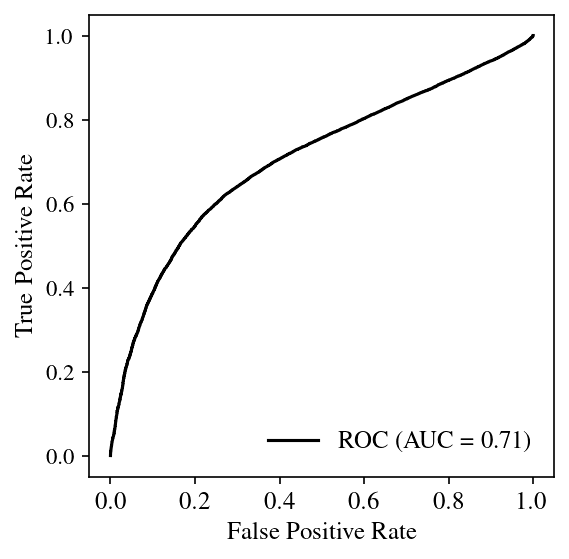

In [11]:
from rozlib.libs.plotting.plotting import plot_roc

"""
Look at ROC at word level using hhi or surprisal (the score is selected in prev cell)
"""


config_matplot_for_latex(12)

def make_roc_for_word_level(
        idioms_scores,
        literals_scores,
        use_surprisal: bool

):
    # Step 1: Combine scores and labels
    scores = np.array(idioms_scores + literals_scores)

    # if use_surprisal:
    #     # surprisal scores run the opposite direction (they are low for idioms)
    #     labels = np.array([0] * len(idioms_scores) + [1] * len(literals_scores))
    # else:
    # hhi scores are *high* for idioms
    labels = np.array([1] * len(idioms_scores) + [0] * len(literals_scores))


    # sampleing is unnecessary! TPR and FPR (for roc) are not affected by relatiave class sizes
    # print(sum(labels)/len(labels))
    # labels, scores = sample_evenly(labels, scores, 1000000)
    # print(sum(labels)/len(labels))

    fig = plot_roc(labels, scores,
             # flip_threshold_sign=use_surprisal,
             flip_threshold_sign=False,
             # title="ROC Curve Using Contextual Constraint",
             add_axes_labels=True,
             show_thresholds=False,
                   figsize=(4,4)
             )

    save_fig(fig, "idioms_roc.pdf")

# note that ROC is not affected by sample class imbalance!

make_roc_for_word_level(idioms_scores, literals_scores, use_surprisal)